In [1382]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast

In [1818]:
sns.set(rc={'figure.figsize':(15,8)})

In [1644]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('result_std1.csv')
df['date'] = pd.to_datetime(df.date)

df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [1645]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')
df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [1646]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [1647]:
df.loc[(df.duplicated(subset=['date', 'sorted_pair'], keep='first'))].sort_values(by=['date', 'sorted_pair'])

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,open_price_scnd_stock,open_date,close_limit,stop_limit,halflife,days_open,data_ini,data_fin,setor,sorted_pair


In [1648]:
def result_calculator(row):
    
    
    long_result = row['price_fst_stock'] - row['open_price_first_stock']
    short_result = row['open_price_scnd_stock'] - row['price_scnd_stock']
    
#     long_result = row['open_price_first_stock'] - row['price_fst_stock']
#     short_result = row['price_scnd_stock'] - row['open_price_scnd_stock']

    result = long_result + short_result
    
    if row['residual_open'] > row['std_open_residual']:
        result = - result

    return result 

In [1649]:
cond = (df.status.isin(['True', 'close']))

In [1650]:
df.loc[cond, 'result'] = df.loc[cond].apply(lambda row: result_calculator(row), axis=1)

In [1651]:
# Cash Neutral

quant2 = df.loc[cond].open_price_first_stock / df.loc[cond].open_price_scnd_stock
quant1 = 1

long_result = df.loc[cond,'price_fst_stock'] - df.loc[cond,'open_price_first_stock']
short_result = df.loc[cond,'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']

result = (quant1 * long_result) + (short_result * quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_cash_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_cash_neutral'] = - result


In [1652]:
# Beta Neutral

quant2 = df.loc[cond].beta_open
quant1 = 1

result = (quant1) * (df.loc[cond, 'price_fst_stock'] - df.loc[cond, 'open_price_first_stock']) + (df.loc[cond, 'open_price_scnd_stock'] - df.loc[cond,'price_scnd_stock']) * (quant2)

df.loc[cond,'cash'] = (quant1 * df.loc[cond, 'open_price_first_stock']) + (quant2 * df.loc[cond, 'open_price_scnd_stock'])

df.loc[cond, 'result_beta_neutral'] = result
df.loc[(cond) & (df.residual_open > df.std_open_residual), 'result_beta_neutral'] = - result

In [1654]:
closed = df.loc[df.status=='close'].copy()

closed['is_profit'] = closed['result'] > 0
closed['is_profit_CN'] = closed['result_cash_neutral'] > 0
closed['is_profit_BN'] = closed['result_beta_neutral'] > 0


In [1717]:
result = closed[['result', 'result_cash_neutral', 'result_beta_neutral']].sum()
accuracy = closed[['is_profit', 'is_profit_CN', 'is_profit_BN']].mean()

In [1718]:
result_table = {'result': result.values,
                'accuracy': accuracy.values,                
               }
pd.DataFrame(result_table, index=['normal', 'cash_neutral', 'beta_neutral'])

,result,accuracy
normal,131.940000,0.515826
cash_neutral,135.488846,0.511137
beta_neutral,128.220265,0.501758


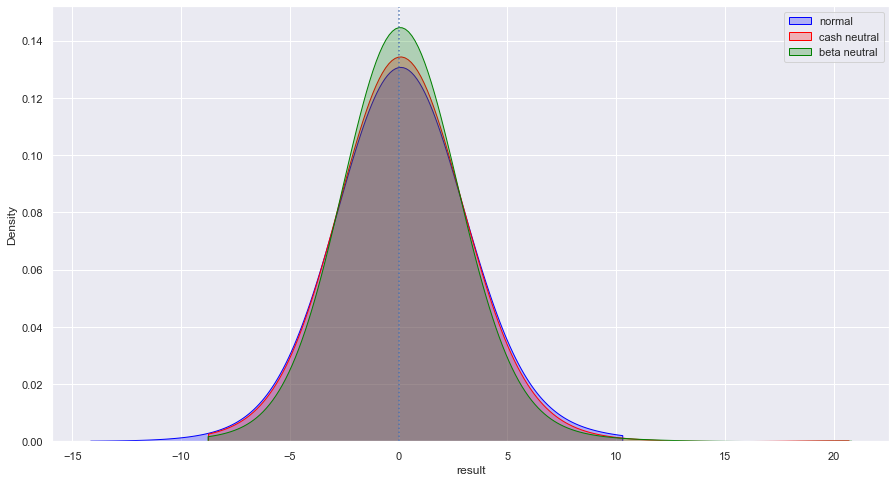

In [1819]:
sns.kdeplot(x=closed.result, color='blue', label='normal', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_cash_neutral, color='red', label='cash neutral', bw_adjust=5, cut=0, fill=True)
sns.kdeplot(x=closed.result_beta_neutral, color='green', label='beta neutral', bw_adjust=5, cut=0, fill=True)

plt.axvline(x=0, linestyle='dotted')
plt.legend()
plt.show()

In [1728]:
# Close by residual
closed_by_residual = closed.loc[abs(df.last_residual) < df.close_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_residual

,sum,count
result,76.890000,27.0
result_cash_neutral,59.558230,27.0
result_beta_neutral,80.075961,27.0


In [1729]:
# stop by stop
closed_by_stop = closed.loc[abs(df.last_residual) > df.stop_limit,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_stop

,sum,count
result,-221.340000,322.0
result_cash_neutral,-210.390263,322.0
result_beta_neutral,-305.667564,322.0


In [1730]:
# stop by halflife
closed_by_halflife = closed.loc[closed.days_open > closed.halflife,['result', 'result_cash_neutral', 'result_beta_neutral']].agg([sum, 'count']).T
closed_by_halflife

,sum,count
result,283.830000,521.0
result_cash_neutral,288.459338,521.0
result_beta_neutral,355.085527,521.0


In [1661]:
# closed = closed.loc[closed.halflife.between(0,21)]

In [1736]:
halfyear_accuracy

,is_profit,is_profit_CN,is_profit_BN
date,,,
2019-07-31,0.500000,0.625000,0.687500
2020-01-31,0.540741,0.511111,0.548148
2020-07-31,0.521053,0.521053,0.447368
2021-01-31,0.504587,0.532110,0.559633
2021-07-31,0.428571,0.436090,0.466165
2022-01-31,0.568807,0.559633,0.477064
2022-07-31,0.534161,0.503106,0.515528


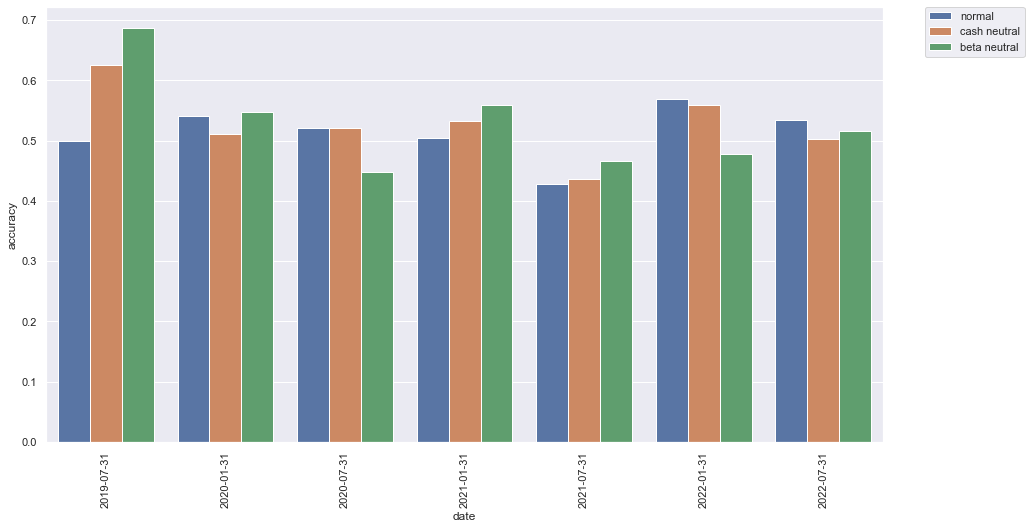

In [1820]:
# Halfyear accuracy
halfyear_accuracy = closed.set_index('date').resample('6M')[['is_profit', 'is_profit_CN', 'is_profit_BN']].mean().reset_index()
halfyear_accuracy.columns = ['date', 'normal', 'cash neutral', 'beta neutral']
halfyear_accuracy['date'] = halfyear_accuracy['date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='date', value_name='accuracy')

sns.barplot(x='date', y='accuracy', hue='variable', data=halfyear_accuracy)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

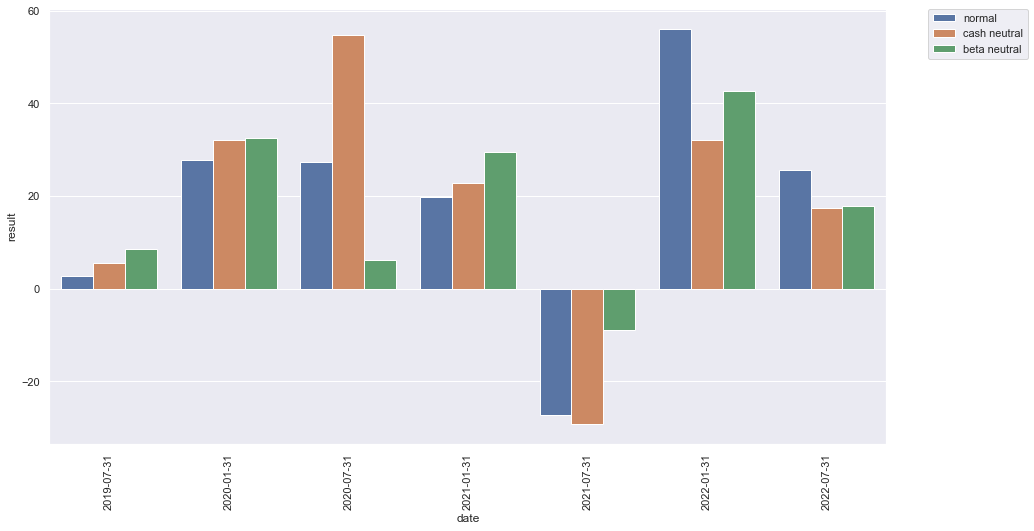

In [1821]:
# Halfyear results
halfyear_results = closed.set_index('date').resample('6M')[['result', 'result_cash_neutral', 'result_beta_neutral']].sum().reset_index()
halfyear_results.columns = ['date', 'normal', 'cash neutral', 'beta neutral']
halfyear_results['date'] = halfyear_results.date.dt.date
halfyear_results = halfyear_results.melt(id_vars='date', value_name='result')

sns.barplot(x='date', y='result', hue='variable', data=halfyear_results)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [1767]:
closed_daily = closed.groupby('date').agg({'result':sum, 'result_cash_neutral':sum,'result_beta_neutral':sum})

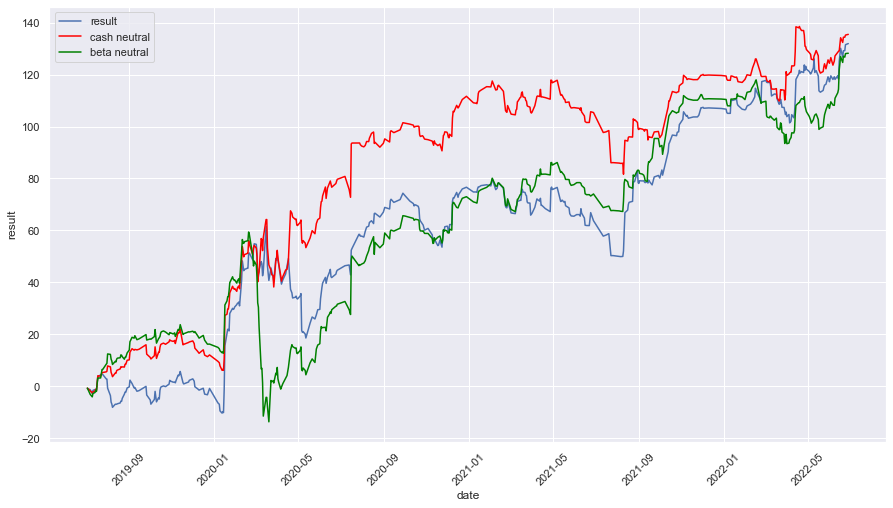

In [1822]:
sns.lineplot(x=closed_daily.index, y=closed_daily.result.cumsum(), label='result')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_cash_neutral.cumsum(),color='red', label='cash neutral')
sns.lineplot(x=closed_daily.index, y=closed_daily.result_beta_neutral.cumsum(),color='green', label='beta neutral')


plt.xticks(rotation=45)
plt.show()

[]

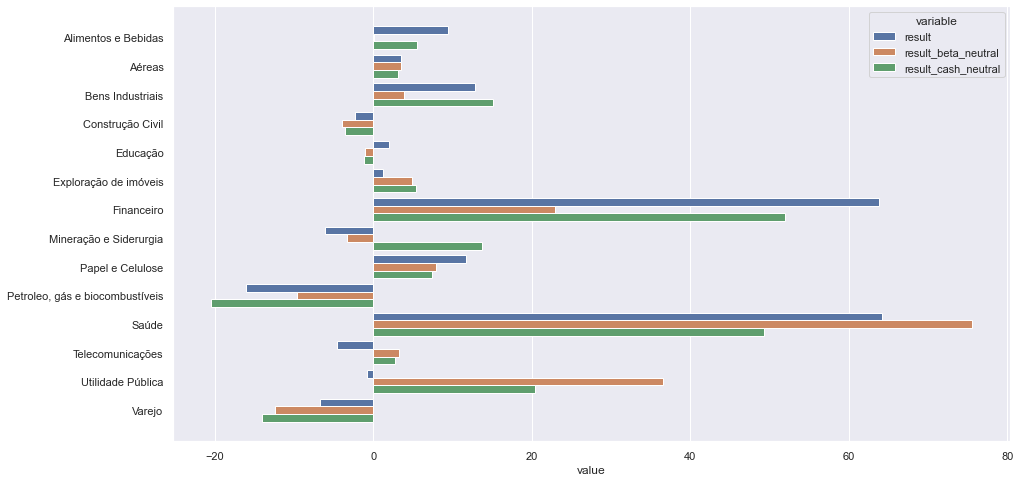

In [1824]:
closed_setor = closed[['setor', 'result', 'result_cash_neutral', 'result_beta_neutral']].melt(id_vars='setor')
closed_setor = closed_setor.groupby(['setor', 'variable'], as_index=False).sum()

plt.figure(figsize=(15,8))

sns.barplot(y='setor', x='value', hue='variable', data=closed_setor, orient='h')
# plt.grid(axis='x')
plt.ylabel(None)
plt.plot()

In [1801]:
closed_setor.pivot(index='setor', columns='variable', values='value')

variable,result,result_beta_neutral,result_cash_neutral
setor,,,
Alimentos e Bebidas,9.47,0.132410,5.536947
Aéreas,3.44,3.525172,3.094137
Bens Industriais,12.83,3.894289,15.153790
Construção Civil,-2.35,-3.968271,-3.543908
Educação,1.98,-1.031729,-1.119002
Exploração de imóveis,1.16,4.911189,5.359375
Financeiro,63.86,22.946025,51.993596
Mineração e Siderurgia,-6.14,-3.383387,13.682216
Papel e Celulose,11.64,7.932651,7.439877


[]

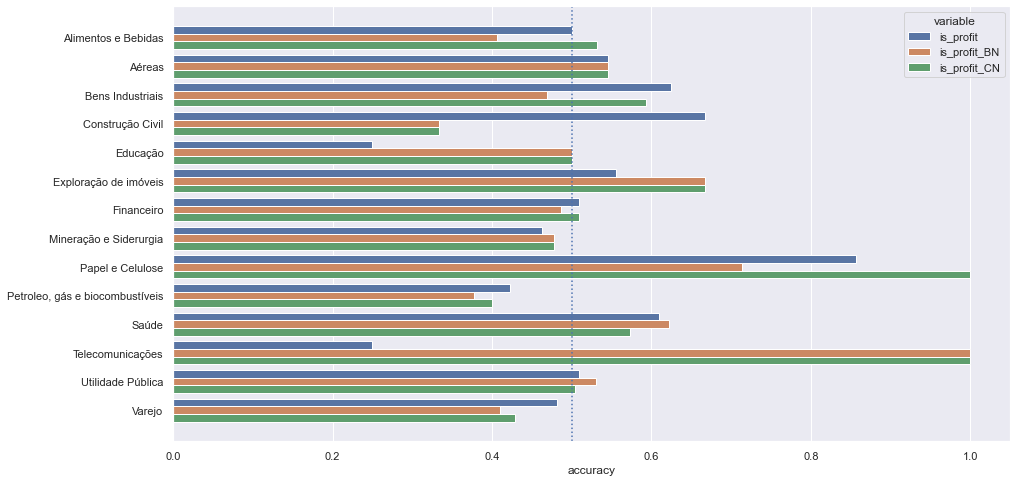

In [1828]:
closed_setor_accuracy = closed[['setor', 'is_profit', 'is_profit_CN', 'is_profit_BN']].melt(id_vars='setor', value_name='accuracy')
closed_setor_accuracy = closed_setor_accuracy.groupby(['setor', 'variable'], as_index=False).mean()
sns.barplot(y='setor', x='accuracy', hue='variable', data=closed_setor_accuracy, orient='h', )
plt.axvline(x=0.5, linestyle='dotted')
plt.ylabel(None)
# plt.grid(axis='x')
plt.plot()

In [1834]:
closed_setor_accuracy.pivot(index='setor', columns='variable', values='accuracy')

variable,is_profit,is_profit_BN,is_profit_CN
setor,,,
Alimentos e Bebidas,0.500000,0.406250,0.531250
Aéreas,0.545455,0.545455,0.545455
Bens Industriais,0.625000,0.468750,0.593750
Construção Civil,0.666667,0.333333,0.333333
Educação,0.250000,0.500000,0.500000
Exploração de imóveis,0.555556,0.666667,0.666667
Financeiro,0.509434,0.486792,0.509434
Mineração e Siderurgia,0.462687,0.477612,0.477612
Papel e Celulose,0.857143,0.714286,1.000000


In [1479]:
pair_closed = closed.groupby('sorted_pair').agg(
    result_sum=('result', 'sum'),
    result_mean=('result', 'mean'),
    result_sum_CN=('result_cash_neutral', 'sum'),
    result_mean_CN=('result_cash_neutral', 'mean'),
    count=('result', 'count'),
    accuracy=('is_profit', 'mean'),
    accuracy_CN=('is_profit_CN', 'mean'),
    sector=('setor', 'last')
    )

pair_closed.loc[pair_closed['count']>3].sort_values(by=['accuracy_CN', 'count'], ascending=False).head(25)

,result_sum,result_mean,result_sum_CN,result_mean_CN,count,accuracy,accuracy_CN,sector
sorted_pair,,,,,,,,
"(KLBN11, SUZB3)",11.46,1.432500,10.438215,1.304777,8,0.875000,1.000000,Papel e Celulose
"(TIMS3, VIVT3)",-3.15,-0.787500,2.917459,0.729365,4,0.250000,1.000000,Telecomunicações
"(BBDC3, BBDC4)",0.83,0.092222,1.356925,0.150769,9,0.666667,0.888889,Financeiro
"(BBAS3, ITSA4)",1.30,0.216667,3.460445,0.576741,6,0.666667,0.833333,Financeiro
"(ELET6, EQTL3)",6.32,0.632000,8.158183,0.815818,10,0.700000,0.800000,Utilidade Pública
"(EGIE3, SBSP3)",-1.31,-0.262000,-1.123499,-0.224700,5,0.400000,0.800000,Utilidade Pública
"(ITSA4, ITUB4)",1.20,0.240000,1.274313,0.254863,5,0.600000,0.800000,Financeiro
"(ABEV3, BRFS3)",15.57,1.946250,10.701986,1.337748,8,0.750000,0.750000,Alimentos e Bebidas
"(BBAS3, BBSE3)",4.36,0.545000,5.546111,0.693264,8,0.750000,0.750000,Financeiro


In [55]:
# pair_closed.to_excel('pares_parcial.xlsx')